# Irrigation System Model

Paul T. Grogan <pgrogan@stevens.edu>, Stevens Institute of Technology

## Background

This notebook implements the replicator dynamics model from:

David J. Yu, Murad R. Qubbaj, Rachata Muneepeerakul, John M. Anderies, and Rimjhim M. Aggerwal (2015). "Effect of infrastructure design on commons dilemmas in social-ecological system dynamics," _Proceedings of the National Academy of Sciences_, Vol. 112, No. 43, pp. 13207-13212. doi: [10.1073/pnas.1410688112](https://doi.org/10.1073/pnas.1410688112)

In [136]:
import itertools
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize, LinearConstraint
import warnings

## Model Parameters

Default model parameters from Table S3.

In [137]:
w = 0.2 # wage for outside employment (Table S3)
psi = 0.2 # half-saturation point of L_m yielding I_max/2 infrastructure efficiency
epsilon = 0.125 # half-width of the threshold slope for infrastructure maintenance
I_max = 1.0 # maximum infrastructure efficiency
S = 100 # water resource availability
Q_max = I_max * S # maximum irrigation water available
j = 0.3 # output elasticity of farming labor for agricultural yield
k = 0.4 # output elasticity of irrigated water for agricultural yield
p = 1.0 # price per unit of agricultural yield
b = 1.0 # productivity coefficient for the inputs of production
a_1 = 1.0 # acerage of farmer in village 1
a_2 = 1.0 # acerage of farmer in village 2
A = a_1 + a_2 # total farming area
l = 1.0 # average labor per farmer
N_1 = 50 # number of farmers in village 1
N_2 = 50 # number of farmers in village 2
N = N_1 + N_2 # total population
L = N * l # total labor
R = 0.0 # total amount of freely available alternative water
r_1 = 0.0 # amount of alternative water available to a farmer in village 1
r_2 = 0.0 # amount of alternative water available to a farmer in village 2
gamma_s = 0.05 # maximum enforcement cost for monitoring opportunists in the same village
gamma_o = 0.1 # maximum enforcement cost for monitoring opportunists in the other village
delta = 1.4 # maximum penalty cost imposed on opportunists
sigma = 0.9 # tolerance for water theft shown by group conformists when water is abundant in the system

# helper variables
c_1 = p * b * a_1 ** (1 - j - k)
c_2 = p * b * a_2 ** (1 - j - k)

## Infrastructure Maintenance

Effect of maintenance on infrastructure efficiency from Eq. (S3) modified to make the domain $[0, L]$ rather than $[0, 1]$.

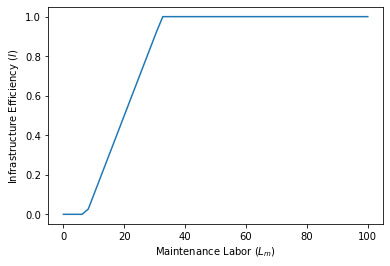

In [138]:
# efficiency of infrastructure operation (Eq. S3)
def I(L_m):
  if L_m / L < psi - epsilon:
    return 0
  elif L_m / L <= psi + epsilon:
    return ( I_max / (2 * epsilon) ) * (L_m / L - psi + epsilon)
  else:
    return I_max

plt.figure()
plt.plot(np.linspace(0,L), [I(L_m) for L_m in np.linspace(0,L)])
plt.xlabel("Maintenance Labor ($L_m$)")
plt.ylabel("Infrastructure Efficiency ($I$)")
plt.show()

## Optimal Maintenance of Infrastructure

Based on aggregate income in Eq. (S5) and optimal labor allocation in Eq. (S6).

In [139]:
# aggregate income as a function of labor allocation (Eq. S5)
def PI(L_f, L_m, L_e):
  farming_production = p * b * L_f ** j * (I(L_m) * S + R) ** k * A ** (1 - j - k)
  outside_employment = w * L_e
  return farming_production + outside_employment

# solve for efficient infrastructure maintenance (Eq. S6)
result = minimize(
      lambda x: -1 * PI(x[0], x[1], x[2]), 
      [L/3, L/3, L/3], 
      constraints=LinearConstraint([1, 1, 1], 0, L),
      bounds = [
        (0, L),
        (0, L),
        (0, L)
      ]
  )
if not result.success: raise RuntimeError(result)
L_f_star, L_m_star, L_e_star = result.x
print(f"L_f_star={L_f_star:.2f}, L_m_star={L_m_star:.2f}, L_e_star={L_e_star:.2f}")

L_f_star=33.75, L_m_star=32.50, L_e_star=33.75


## Actor Payoff Functions

Based on payoffs for two strategies ($G$ and $O$) for villages 1 and 2 in Eq. (S12-S15).

In [140]:
# income for village 1 group conformists (Eq. S12)
def pi_1_G(l_f_G, l_m_G, l_e_G, q_1_G, X_1, X_2, Q, Q_star):
  farming_production =  c_1 * l_f_G ** j * (q_1_G + r_1) ** k
  outside_employment = w * l_e_G
  enforcement_cost = gamma_s * (1 - X_1) + gamma_o * (1 - X_2)
  return max(0, farming_production + outside_employment - enforcement_cost)

In [141]:
# income for village 1 opportunists (Eq. S13)
def pi_1_O(l_f_O, l_e_O, q_1_O, X_1, X_2, Q, Q_star):
  farming_production = c_1 * l_f_O ** j * (q_1_O + r_1) ** k
  outside_employment = w * l_e_O
  if Q_star > 0:
    punishment_cost = delta * ( 1 - sigma * Q / Q_star ) * q_1_O * ( X_1 + X_2 ) / 2
  else:
    punishment_cost = 0
  return farming_production + outside_employment - punishment_cost

In [142]:
# income for village 2 group conformists (Eq. S14)
def pi_2_G(l_f_G, l_m_G, l_e_G, q_2_G, X_1, X_2, Q, Q_star):
  farming_production = c_2 * l_f_G ** j * (q_2_G + r_2) ** k
  outside_employment = w * l_e_G
  enforcement_cost = gamma_s * (1 - X_2) + gamma_o * (1 - X_1)
  return max(0, farming_production + outside_employment - enforcement_cost)

In [143]:
# income for village 2 opportunists (Eq. S15)
def pi_2_O(l_f_O, l_e_O, q_2_O, X_1, X_2, Q, Q_star):
  farming_production = c_2 * l_f_O ** j * (q_2_O + r_2) ** k
  outside_employment = w * l_e_O
  if Q_star > 0:
    punishment_cost = delta * ( 1 - sigma * Q / Q_star ) * q_2_O * ( X_1 + X_2 ) / 2
  else:
    punishment_cost = 0
  return farming_production + outside_employment - punishment_cost

## Operational Decisions

Decision policies employed by actors for the two strategies ($G$ and $O$) for villages 1 and 2 described in Supplement pp. 3-4.

In [144]:
# village 1 opportunist labor allocation and water usage; symmetric case (p. 3)
def get_village_1_opportunist_decisions_symmetric(X_1, X_2, Q, Q_star):
  # opportunists allocate labor and utilize water to maximize income
  result = minimize(
      lambda x: -1*pi_1_O(x[0], x[1], x[2], X_1, X_2, Q, Q_star), 
      [l/2, l/2, Q / N / 2], 
      constraints=[
        LinearConstraint([1, 1, 0], 0, l), # labor allocation cannot exceed l
      ],
      bounds=[
        (0, l),
        (0, l),
        (0, Q / N) # steal up to an equal share of water
      ],
      method="nelder-mead"
  )
  if not result.success: raise RuntimeError(result)
  l_1_f_O, l_1_e_O, q_1_O = result.x
  return l_1_f_O, l_1_e_O, q_1_O

In [145]:
# village 2 opportunist labor allocation and water usage; symmetric case (p. 3)
def get_village_2_opportunist_decisions_symmetric(X_1, X_2, Q, Q_star):
  # opportunists allocate labor and utilize water to maximize income
  result = minimize(
      lambda x: -1*pi_2_O(x[0], x[1], x[2], X_1, X_2, Q, Q_star), 
      [l/2, l/2, Q / N / 2], 
      constraints=[
        LinearConstraint([1, 1, 0], 0, l), # labor allocation cannot exceed l
      ],
      bounds=[
        (0, l),
        (0, l),
        (0, Q / N) # steal up to an equal share of water
      ],
      method="nelder-mead"
  )
  if not result.success: raise RuntimeError(result)
  l_2_f_O, l_2_e_O, q_2_O = result.x
  return l_2_f_O, l_2_e_O, q_2_O

In [146]:
# village 1 group conformist water usage; symmetric case (p. 3)
def get_village_1_group_conformists_water_symmetric(X_1, X_2, Q, Q_star, Q_1_O, Q_2_O):
  N_1_G = X_1 * N_1 # number of group conformists in village 1
  N_2_G = X_2 * N_2 # number of group conformists in village 2
  N_G = N_1_G + N_2_G # total number of group conformists
  Q_O = Q_1_O + Q_2_O # total water used by opportunists
  # group conformists use their "fair share" of the remaining water
  q_1_G = ( Q - Q_O ) / N_G
  return q_1_G

In [147]:
# village 2 group conformist water usage; symmetric case (p. 3)
def get_village_2_group_conformists_water_symmetric(X_1, X_2, Q, Q_star, Q_1_O, Q_2_O):
  N_1_G = X_1 * N_1 # number of group conformists in village 1
  N_2_G = X_2 * N_2 # number of group conformists in village 2
  N_G = N_1_G + N_2_G # total number of group conformists
  Q_O = Q_1_O + Q_2_O # total water used by opportunists
  # group conformists use their "fair share" of the remaining water
  q_2_G = ( Q - Q_O ) / N_G
  return q_2_G

In [148]:
# village 1 opportunist labor allocation and water usage; asymmetric case (p. 4)
def get_village_1_opportunist_decisions_asymmetric(X_1, X_2, Q, Q_star):
  # opportunists allocate labor and utilize water to maximize income
  result = minimize(
      lambda x: -1*pi_1_O(x[0], x[1], x[2], X_1, X_2, Q, Q_star), 
      [l/2, l/2, Q / N_1 / 2], 
      constraints=[
        LinearConstraint([1, 1, 0], 0, l), # labor allocation cannot exceed l
      ],
      bounds=[
        (0, l),
        (0, l),
        (0, Q / N_1) # steal up to an equal share of water in village 1
      ],
      method="nelder-mead"
  )
  if not result.success: raise RuntimeError(result)
  l_1_f_O, l_1_e_O, q_1_O = result.x
  return l_1_f_O, l_1_e_O, q_1_O

In [149]:
# village 1 group conformist water usage; asymmetric case (p. 3)
def get_village_1_group_conformists_water_asymmetric(X_1, X_2, Q, Q_1_O):
  N_1_G = X_1 * N_1 # number of group conformists in village 1
  N_2_G = X_2 * N_2 # number of group conformists in village 2
  N_G = N_1_G + N_2_G # total number of group conformists
  # group conformists use their "fair share" of the (remaining) water
  q_1_G = min( Q / N_G, ( Q - Q_1_O ) / N_1_G )
  return q_1_G

In [150]:
# village 2 opportunist labor allocation and water usage; asymmetric case (p. 4)
def get_village_2_opportunist_decisions_asymmetric(X_1, X_2, Q, Q_star, Q_1_G, Q_1_O):
  # opportunists allocate labor and utilize water to maximize income
  result = minimize(
      lambda x: -1*pi_2_O(x[0], x[1], x[2], X_1, X_2, Q, Q_star), 
      [l/2, l/2, max(0, (Q - Q_1_G - Q_1_O) / N_2 / 2)], 
      constraints=[
        LinearConstraint([1, 1, 0], 0, l), # labor allocation cannot exceed l
      ],
      bounds=[
        (0, l),
        (0, l),
        (0, max(0, (Q - Q_1_G - Q_1_O) / N_2)) # steal up to an equal share of water
      ],
      method="nelder-mead"
  )
  if not result.success: raise RuntimeError(result)
  l_2_f_O, l_2_e_O, q_2_O = result.x
  return l_2_f_O, l_2_e_O, q_2_O

In [151]:
# village 2 group conformist water usage; asymmetric case (p. 3)
def get_village_2_group_conformists_water_asymmetric(X_1, X_2, Q, Q_1_G, Q_1_O, Q_2_O):
  N_2_G = X_2 * N_2 # number of group conformists in village 2
  # group conformists use their "fair share" of the remaining water
  q_2_G = max(0, ( Q - Q_1_O - Q_1_G - Q_2_O) / N_2_G)
  return q_2_G

In [152]:
# village 1 group conformist labor allocation (p. 3)
def get_village_1_group_conformists_labor(X_1, X_2, Q, Q_star, q_1_G):
  # group conformists contribute their "fair share" of the optimal labor
  l_1_m_G = L_m_star / N
  # group conformists allocate labor to maximize income
  result = minimize(
      lambda x: -1*pi_1_G(x[0], l_1_m_G, x[1], q_1_G, X_1, X_2, Q, Q_star),
      [max(0, (l - l_1_m_G)/2), max(0, (l - l_1_m_G)/2)],
      constraints=[
        LinearConstraint([1, 1], max(0, l - l_1_m_G), max(0, l - l_1_m_G)), # labor allocation cannot exceed l
      ],
      bounds=[
        (0, max(0, l - l_1_m_G)),
        (0, max(0, l - l_1_m_G))
      ],
      method="nelder-mead"
  )
  if not result.success: raise RuntimeError(result)
  l_1_f_G, l_1_e_G = result.x
  return l_1_m_G, l_1_f_G, l_1_e_G

In [153]:
# village 2 group conformist labor allocation (p. 3)
def get_village_2_group_conformists_labor(X_1, X_2, Q, Q_star, q_2_G):
  # group conformists contribute their "fair share" of the optimal labor
  l_2_m_G = L_m_star / N
  # group conformists allocate labor to maximize income
  result = minimize(
      lambda x: -1*pi_2_G(x[0], l_2_m_G, x[1], q_2_G, X_1, X_2, Q, Q_star),
      [max(0, (l - l_2_m_G)/2), max(0, (l - l_2_m_G)/2)],
      constraints=[
        LinearConstraint([1, 1], max(0, l - l_2_m_G), max(0, l - l_2_m_G)), # labor allocation cannot exceed l
      ],
      bounds=[
        (0, max(0, l - l_2_m_G)),
        (0, max(0, l - l_2_m_G))
      ],
      method="nelder-mead"
  )
  if not result.success: raise RuntimeError(result)
  l_2_f_G, l_2_e_G = result.x
  return l_2_m_G, l_2_f_G, l_2_e_G

## Payoff Outcomes

Resulting payoffs based on decisions during one period.

In [154]:
# get the resulting payoffs based on system state
def get_payoffs(X_1, X_2, symmetric=True):
  N_1_G = X_1 * N_1 # number of group conformists in village 1
  N_2_G = X_2 * N_2 # number of group conformists in village 2
  N_G = N_1_G + N_2_G # total number of group conformists

  # group conformists assume everyone contributes to efficient solution
  L_m = N_G * L_m_star / N # total labor for canal maintenance
  Q = I(L_m) * S # total water available
  Q_star = I(L_m_star) * S # total water available under optimal maintenance

  if symmetric:
    l_1_f_O, l_1_e_O, q_1_O = get_village_1_opportunist_decisions_symmetric(X_1, X_2, Q, Q_star)
    l_2_f_O, l_2_e_O, q_2_O = get_village_2_opportunist_decisions_symmetric(X_1, X_2, Q, Q_star)
    Q_1_O = q_1_O * (1 - X_1) * N_1
    Q_2_O = q_2_O * (1 - X_2) * N_2
    q_1_G = get_village_1_group_conformists_water_symmetric(X_1, X_2, Q, Q_star, Q_1_O, Q_2_O)
    q_2_G = get_village_2_group_conformists_water_symmetric(X_1, X_2, Q, Q_star, Q_1_O, Q_2_O)
  else:
    l_1_f_O, l_1_e_O, q_1_O = get_village_1_opportunist_decisions_asymmetric(X_1, X_2, Q, Q_star)
    Q_1_O = q_1_O * (1 - X_1) * N_1
    q_1_G = get_village_1_group_conformists_water_asymmetric(X_1, X_2, Q, Q_1_O)
    Q_1_G = q_1_G * X_1 * N_1
    l_2_f_O, l_2_e_O, q_2_O = get_village_2_opportunist_decisions_asymmetric(X_1, X_2, Q, Q_star, Q_1_G, Q_1_O)
    Q_2_O = q_2_O * (1 - X_2) * N_2
    q_2_G = get_village_2_group_conformists_water_asymmetric(X_1, X_2, Q, Q_1_G, Q_1_O, Q_2_O)
  
  l_1_m_G, l_1_f_G, l_1_e_G = get_village_1_group_conformists_labor(X_1, X_2, Q, Q_star, q_1_G)
  l_2_m_G, l_2_f_G, l_2_e_G = get_village_2_group_conformists_labor(X_1, X_2, Q, Q_star, q_2_G)

  return (
      pi_1_G(l_1_f_G, l_1_m_G, l_1_e_G, q_1_G, X_1, X_2, Q, Q_star), 
      pi_1_O(l_1_f_O, l_1_e_O, q_1_O, X_1, X_2, Q, Q_star), 
      pi_2_G(l_2_f_G, l_2_m_G, l_2_e_G, q_2_G, X_1, X_2, Q, Q_star),
      pi_2_O(l_2_f_O, l_2_e_O, q_2_O, X_1, X_2, Q, Q_star),
  )

## Replicator Dynamics

Updates strategy decisions as a result of payoff outcomes following the replicator equations in Eq. (S1-S2).

In [155]:
# replicator dynamics (Eq. S1 and S2)
def dX_dt(t, X, symmetric):
  payoffs = get_payoffs(X[0], X[1], symmetric)
  return [
    X[0] * ( payoffs[0] - ( payoffs[0] * X[0] + payoffs[1] * (1 - X[0]) ) ),
    X[1] * ( payoffs[2] - ( payoffs[2] * X[1] + payoffs[3] * (1 - X[1]) ) )
  ]

## Policy Trajectory

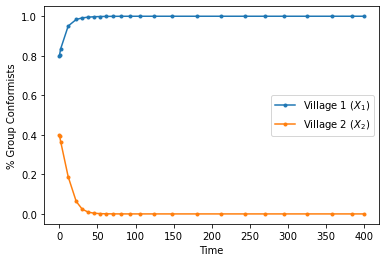

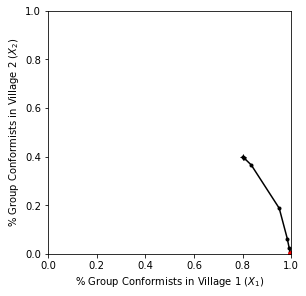

In [156]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  result = solve_ivp(dX_dt, [0, 400], [0.8, 0.4], args=(False,))

plt.plot(result.t, result.y[0], ".-", label="Village 1 ($X_1$)")
plt.plot(result.t, result.y[1], ".-", label="Village 2 ($X_2$)")
plt.xlabel("Time")
plt.ylabel("% Group Conformists")
plt.legend()
plt.show()

fig, ax = plt.subplots(constrained_layout=True)
plt.plot(result.y[0], result.y[1], "k.-")
plt.plot(result.y[0,0], result.y[1,0], "k+")
plt.plot(result.y[0,-1], result.y[1,-1], "ro")
plt.xlim([0,1])
plt.ylim([0,1])
ax.set_aspect('equal', 'box')
plt.xlabel("% Group Conformists in Village 1 ($X_1$)")
plt.ylabel("% Group Conformists in Village 2 ($X_2$)")
plt.show()

## Phase Space Diagram

In [157]:
n_steps = 20
x1 = np.linspace(0.05, 0.95, n_steps, endpoint=True)
x2 = np.linspace(0.05, 0.95, n_steps, endpoint=True)
X1, X2 = np.meshgrid(x1, x2)
ij = list(itertools.product(range(n_steps), range(n_steps)))
results = Parallel(n_jobs=-1)(delayed(solve_ivp)(dX_dt, [0,100], [X1[i1,i2], X2[i1,i2]], args=(False,)) for (i1,i2) in ij)

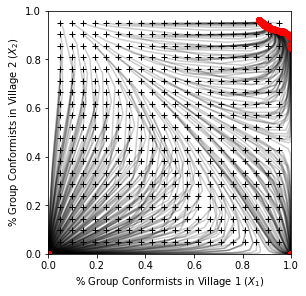

In [158]:
fig, ax = plt.subplots(constrained_layout=True)
for result in results:
  plt.plot(result.y[0], result.y[1], "k-", alpha=0.2)
  plt.plot(result.y[0,0], result.y[1,0], "k+")
for result in results:
  plt.plot(result.y[0,-1], result.y[1,-1], "ro")
plt.xlabel("% Group Conformists in Village 1 ($X_1$)")
plt.ylabel("% Group Conformists in Village 2 ($X_2$)")
plt.xlim([0,1])
plt.ylim([0,1])
ax.set_aspect('equal', 'box')
plt.show()

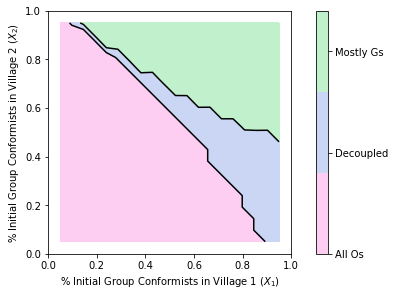

In [159]:
fig, ax = plt.subplots(constrained_layout=True)
Z = np.zeros((n_steps, n_steps))
for i, (i1,i2) in enumerate(ij):
  Z[i1,i2] = (results[i].y[0,-1] + results[i].y[1,-1])/2
CS = plt.contourf(X1, X2, Z, colors=["#fecdf2", "#cad6f3", "#c1f1cc"], levels=2)
plt.contour(X1, X2, Z, levels=2, colors="k")
plt.xlabel("% Initial Group Conformists in Village 1 ($X_1$)")
plt.ylabel("% Initial Group Conformists in Village 2 ($X_2$)")
cbar = fig.colorbar(CS, ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(["All Os", "Decoupled", "Mostly Gs"])
plt.xlim([0,1])
plt.ylim([0,1])
ax.set_aspect('equal', 'box')
plt.show()